In [1]:
import pickle
import gzip
import numpy as np
import os
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras import Model



2022-12-08 16:31:27.390188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 16:31:28.273798: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/francescog/Scaricati/AML_Pr_3/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-08 16:31:28.273866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/francescog/Scaricati/AML_Pr_3/venv/lib

In [46]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)
        
def jaccard_similarity(y_train, y_test):
    y_train_f = K.flatten(y_train)
    y_test_f = K.flatten(y_test)
    intersection = K.sum(y_train_f * y_test_f)
    union = K.sum(y_train_f) + K.sum(y_test_f) - intersection
    return intersection / union


def jaccard_loss(y_train, y_test):
    return - jaccard_similarity(y_train, y_test)

In [3]:
def preprocess_train(data, img_size_target):
    X_fin, y_fin = [], []
    video = data['video']
    frames = data['frames']
    label = data['label']
    X = video[:,:,frames]
    y = label[:,:,frames] * 1
    X = cv2.resize(X, (img_size_target, img_size_target), interpolation = cv2.INTER_NEAREST)
    y = cv2.resize(y, (img_size_target, img_size_target), interpolation = cv2.INTER_NEAREST)
    y = (y > 0) * 1.0
    for i in range(len(frames)):
        X_fin.append(X[:,:,i])
        y_fin.append(y[:,:,i])
    return X_fin, y_fin

In [25]:
def preprocess_test(data, img_size_target):
    video = data['video']
    X = video[:,:,:]
    X = cv2.resize(X, (img_size_target, img_size_target), interpolation = cv2.INTER_NEAREST)
    X_fin = []
    for i in range(X.shape[2]):
        X_fin.append(X[:,:,i])
    return X_fin

In [4]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

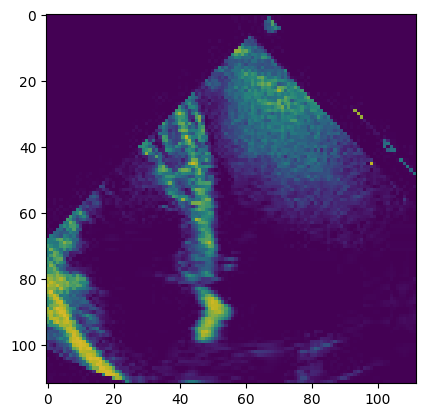

In [5]:
#show the first frame of the first video
import matplotlib.pyplot as plt
plt.imshow(train_data[0]["video"][:,:,45])
plt.imshow(train_data[0]["label"][:,:,45], alpha=0.2)

plt.show()

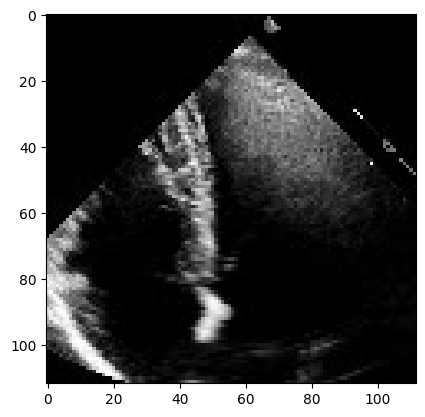

In [8]:
 
X = train_data[0]["video"][:,:,45]
y = train_data[0]["label"][:,:,45]
plt.imshow(X, cmap="gray")
plt.show() 

In [10]:
X, y = [], []
img_size_target = 112
train = train_data
test = test_data
for data in train:
    X_new, y_new = preprocess_train(data, img_size_target)
    X += X_new
    y += y_new
X = np.array(X)
y = np.array(y)


In [124]:
#data augmentation with ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
args = dict(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')
datagen_point = ImageDataGenerator(**args)
datagen_mask = ImageDataGenerator(**args)
seed=1
X_data_aug = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y_data_aug = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
datagen_point.fit(X_data_aug, augment=True, seed=seed)
datagen_mask.fit(y_data_aug, augment=True, seed=seed)
#extend the dataset
new_X, new_y = [], []
for X_batch, y_batch in zip(datagen_point.flow(X_data_aug, batch_size=32, seed=seed), datagen_mask.flow(y_data_aug, batch_size=32, seed=seed)):
    #print(X_batch[0][:,:,0].shape, y_batch[0][:,:,0].shape)
    new_X.append(X_batch[0][:,:,0])
    new_y.append(y_batch[0][:,:,0])
    


In [128]:
len(new_X)

1

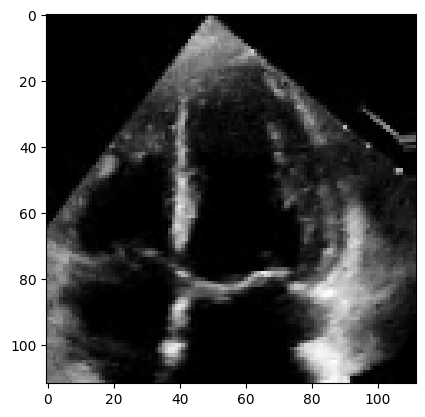

In [131]:
plt.imshow(new_X[0], cmap="gray")
plt.show()

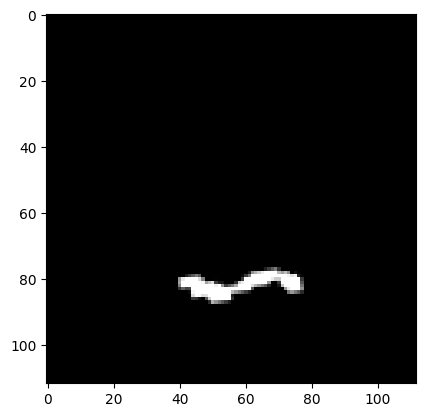

In [130]:
#plot image
plt.imshow(new_y[0], cmap="gray")
plt.show()

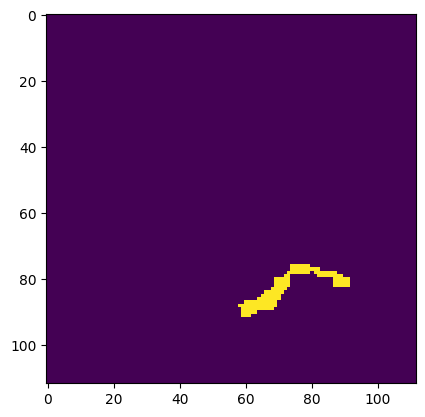

In [11]:

for i in range(len(y)):
    plt.imshow(y[i,:,:])
    plt.show()
    break


In [12]:
int(len(X) * 0.15)

29

In [13]:
n = int(len(X) * 0.15)
X_train = X[:-n,:,:]
X_val = X[-n:,:,:]
y_train = y[:-n,:,:]
y_val = y[-n:,:,:]

In [14]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [15]:
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

model = Model(input_layer, output_layer)

model.compile(loss=jaccard_loss, optimizer="adam", metrics=[jaccard_similarity, 'accuracy'])

epochs = 200
batch_size = 32

early_stopping = EarlyStopping(patience=25, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=epochs,batch_size=batch_size,callbacks=[early_stopping, model_checkpoint])

2022-12-08 16:33:05.827360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-12-08 16:33:05.827481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: asus-vivobook
2022-12-08 16:33:05.827502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: asus-vivobook
2022-12-08 16:33:05.827692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.60.11
2022-12-08 16:33:05.827740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.60.11
2022-12-08 16:33:05.827751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.60.11
2022-12-08 16:33:05.828739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neura

Epoch 1/200
6/6 [==============================] - ETA: 0s - loss: -0.0113 - jaccard_similarity: 0.0113 - accuracy: 0.1670
Epoch 1: val_loss improved from inf to -0.00871, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 22s 3s/step - loss: -0.0113 - jaccard_similarity: 0.0113 - accuracy: 0.1670 - val_loss: -0.0087 - val_jaccard_similarity: 0.0087 - val_accuracy: 0.4152
Epoch 2/200
6/6 [==============================] - ETA: 0s - loss: -0.0144 - jaccard_similarity: 0.0162 - accuracy: 0.6500
Epoch 2: val_loss improved from -0.00871 to -0.01431, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 17s 3s/step - loss: -0.0144 - jaccard_similarity: 0.0162 - accuracy: 0.6500 - val_loss: -0.0143 - val_jaccard_similarity: 0.0143 - val_accuracy: 0.7327
Epoch 3/200
6/6 [==============================] - ETA: 0s - loss: -0.0268 - jaccard_similarity: 0.0284 - accuracy: 0.8785
Epoch 3: val_loss improved from -0.01431 to -0.02336, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 16s 3s/step - loss: -0.0268 - jaccard_similarity: 0.0284 - accuracy: 0.8785 - val_loss: -0.0234 - val_jaccard_similarity: 0.0234 - val_accuracy: 0.8666
Epoch 4/200
6/6 [==============================] - ETA: 0s - loss: -0.0782 - jaccard_similarity: 0.0938 - accuracy: 0.9562
Epoch 4: val_loss improved from -0.02336 to -0.08578, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 16s 3s/step - loss: -0.0782 - jaccard_similarity: 0.0938 - accuracy: 0.9562 - val_loss: -0.0858 - val_jaccard_similarity: 0.0858 - val_accuracy: 0.9913
Epoch 5/200
6/6 [==============================] - ETA: 0s - loss: -0.1654 - jaccard_similarity: 0.1641 - accuracy: 0.9878
Epoch 5: val_loss improved from -0.08578 to -0.11874, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 17s 3s/step - loss: -0.1654 - jaccard_similarity: 0.1641 - accuracy: 0.9878 - val_loss: -0.1187 - val_jaccard_similarity: 0.1187 - val_accuracy: 0.9812
Epoch 6/200
6/6 [==============================] - ETA: 0s - loss: -0.1672 - jaccard_similarity: 0.1763 - accuracy: 0.9737
Epoch 6: val_loss improved from -0.11874 to -0.23350, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 17s 3s/step - loss: -0.1672 - jaccard_similarity: 0.1763 - accuracy: 0.9737 - val_loss: -0.2335 - val_jaccard_similarity: 0.2335 - val_accuracy: 0.9930
Epoch 7/200
6/6 [==============================] - ETA: 0s - loss: -0.3339 - jaccard_similarity: 0.3373 - accuracy: 0.9906
Epoch 7: val_loss improved from -0.23350 to -0.29324, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 17s 3s/step - loss: -0.3339 - jaccard_similarity: 0.3373 - accuracy: 0.9906 - val_loss: -0.2932 - val_jaccard_similarity: 0.2932 - val_accuracy: 0.9909
Epoch 8/200
6/6 [==============================] - ETA: 0s - loss: -0.4009 - jaccard_similarity: 0.3955 - accuracy: 0.9923
Epoch 8: val_loss did not improve from -0.29324
6/6 [==============================] - 14s 2s/step - loss: -0.4009 - jaccard_similarity: 0.3955 - accuracy: 0.9923 - val_loss: -0.2246 - val_jaccard_similarity: 0.2246 - val_accuracy: 0.9872
Epoch 9/200
6/6 [==============================] - ETA: 0s - loss: -0.4072 - jaccard_similarity: 0.4135 - accuracy: 0.9922
Epoch 9: val_loss did not improve from -0.29324
6/6 [==============================] - 14s 2s/step - loss: -0.4072 - jaccard_similarity: 0.4135 - accuracy: 0.9922 - val_loss: -0.2780 - val_jaccard_similarity: 0.2780 - val_accuracy: 0.9884
Epoch 10/200
6/6 [==============================] - ETA: 0s - loss: -0.4243 - jaccard

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 17s 3s/step - loss: -0.4501 - jaccard_similarity: 0.4596 - accuracy: 0.9930 - val_loss: -0.3321 - val_jaccard_similarity: 0.3321 - val_accuracy: 0.9911
Epoch 12/200
6/6 [==============================] - ETA: 0s - loss: -0.4679 - jaccard_similarity: 0.4654 - accuracy: 0.9933
Epoch 12: val_loss did not improve from -0.33206
6/6 [==============================] - 15s 2s/step - loss: -0.4679 - jaccard_similarity: 0.4654 - accuracy: 0.9933 - val_loss: -0.3162 - val_jaccard_similarity: 0.3162 - val_accuracy: 0.9904
Epoch 13/200
6/6 [==============================] - ETA: 0s - loss: -0.4754 - jaccard_similarity: 0.4533 - accuracy: 0.9934
Epoch 13: val_loss improved from -0.33206 to -0.34182, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 17s 3s/step - loss: -0.4754 - jaccard_similarity: 0.4533 - accuracy: 0.9934 - val_loss: -0.3418 - val_jaccard_similarity: 0.3418 - val_accuracy: 0.9914
Epoch 14/200
6/6 [==============================] - ETA: 0s - loss: -0.4873 - jaccard_similarity: 0.4886 - accuracy: 0.9935
Epoch 14: val_loss did not improve from -0.34182
6/6 [==============================] - 12s 2s/step - loss: -0.4873 - jaccard_similarity: 0.4886 - accuracy: 0.9935 - val_loss: -0.3242 - val_jaccard_similarity: 0.3242 - val_accuracy: 0.9903
Epoch 15/200
6/6 [==============================] - ETA: 0s - loss: -0.4937 - jaccard_similarity: 0.4849 - accuracy: 0.9934
Epoch 15: val_loss improved from -0.34182 to -0.38194, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 15s 3s/step - loss: -0.4937 - jaccard_similarity: 0.4849 - accuracy: 0.9934 - val_loss: -0.3819 - val_jaccard_similarity: 0.3819 - val_accuracy: 0.9941
Epoch 16/200
6/6 [==============================] - ETA: 0s - loss: -0.4975 - jaccard_similarity: 0.4997 - accuracy: 0.9935
Epoch 16: val_loss improved from -0.38194 to -0.39255, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 15s 3s/step - loss: -0.4975 - jaccard_similarity: 0.4997 - accuracy: 0.9935 - val_loss: -0.3926 - val_jaccard_similarity: 0.3926 - val_accuracy: 0.9948
Epoch 17/200
6/6 [==============================] - ETA: 0s - loss: -0.4891 - jaccard_similarity: 0.5019 - accuracy: 0.9942
Epoch 17: val_loss did not improve from -0.39255
6/6 [==============================] - 14s 2s/step - loss: -0.4891 - jaccard_similarity: 0.5019 - accuracy: 0.9942 - val_loss: -0.3660 - val_jaccard_similarity: 0.3660 - val_accuracy: 0.9922
Epoch 18/200
6/6 [==============================] - ETA: 0s - loss: -0.5076 - jaccard_similarity: 0.5087 - accuracy: 0.9941
Epoch 18: val_loss did not improve from -0.39255
6/6 [==============================] - 12s 2s/step - loss: -0.5076 - jaccard_similarity: 0.5087 - accuracy: 0.9941 - val_loss: -0.3802 - val_jaccard_similarity: 0.3802 - val_accuracy: 0.9940
Epoch 19/200
6/6 [==============================] - ETA: 0s - loss: -0.5346 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 20s 3s/step - loss: -0.5367 - jaccard_similarity: 0.5374 - accuracy: 0.9945 - val_loss: -0.4126 - val_jaccard_similarity: 0.4126 - val_accuracy: 0.9938
Epoch 22/200
6/6 [==============================] - ETA: 0s - loss: -0.5354 - jaccard_similarity: 0.5343 - accuracy: 0.9947
Epoch 22: val_loss did not improve from -0.41261
6/6 [==============================] - 15s 2s/step - loss: -0.5354 - jaccard_similarity: 0.5343 - accuracy: 0.9947 - val_loss: -0.3776 - val_jaccard_similarity: 0.3776 - val_accuracy: 0.9923
Epoch 23/200
6/6 [==============================] - ETA: 0s - loss: -0.5347 - jaccard_similarity: 0.5151 - accuracy: 0.9942
Epoch 23: val_loss did not improve from -0.41261
6/6 [==============================] - 15s 2s/step - loss: -0.5347 - jaccard_similarity: 0.5151 - accuracy: 0.9942 - val_loss: -0.3741 - val_jaccard_similarity: 0.3741 - val_accuracy: 0.9942
Epoch 24/200
6/6 [==============================] - ETA: 0s - loss: -0.5398 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 18s 3s/step - loss: -0.5398 - jaccard_similarity: 0.5388 - accuracy: 0.9942 - val_loss: -0.4439 - val_jaccard_similarity: 0.4439 - val_accuracy: 0.9948
Epoch 25/200
6/6 [==============================] - ETA: 0s - loss: -0.5476 - jaccard_similarity: 0.5536 - accuracy: 0.9948
Epoch 25: val_loss did not improve from -0.44385
6/6 [==============================] - 15s 2s/step - loss: -0.5476 - jaccard_similarity: 0.5536 - accuracy: 0.9948 - val_loss: -0.4017 - val_jaccard_similarity: 0.4017 - val_accuracy: 0.9932
Epoch 26/200
6/6 [==============================] - ETA: 0s - loss: -0.5537 - jaccard_similarity: 0.5526 - accuracy: 0.9946
Epoch 26: val_loss did not improve from -0.44385
6/6 [==============================] - 16s 3s/step - loss: -0.5537 - jaccard_similarity: 0.5526 - accuracy: 0.9946 - val_loss: -0.3413 - val_jaccard_similarity: 0.3413 - val_accuracy: 0.9930
Epoch 27/200
6/6 [==============================] - ETA: 0s - loss: -0.5450 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 20s 3s/step - loss: -0.5645 - jaccard_similarity: 0.5630 - accuracy: 0.9948 - val_loss: -0.4465 - val_jaccard_similarity: 0.4465 - val_accuracy: 0.9943
Epoch 34/200
6/6 [==============================] - ETA: 0s - loss: -0.5713 - jaccard_similarity: 0.5685 - accuracy: 0.9948
Epoch 34: val_loss did not improve from -0.44649
6/6 [==============================] - 15s 2s/step - loss: -0.5713 - jaccard_similarity: 0.5685 - accuracy: 0.9948 - val_loss: -0.4064 - val_jaccard_similarity: 0.4064 - val_accuracy: 0.9942
Epoch 35/200
6/6 [==============================] - ETA: 0s - loss: -0.5884 - jaccard_similarity: 0.5900 - accuracy: 0.9952
Epoch 35: val_loss did not improve from -0.44649
6/6 [==============================] - 15s 3s/step - loss: -0.5884 - jaccard_similarity: 0.5900 - accuracy: 0.9952 - val_loss: -0.4404 - val_jaccard_similarity: 0.4404 - val_accuracy: 0.9944
Epoch 36/200
6/6 [==============================] - ETA: 0s - loss: -0.5787 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 22s 4s/step - loss: -0.5770 - jaccard_similarity: 0.5747 - accuracy: 0.9952 - val_loss: -0.4491 - val_jaccard_similarity: 0.4491 - val_accuracy: 0.9953
Epoch 45/200
6/6 [==============================] - ETA: 0s - loss: -0.5780 - jaccard_similarity: 0.5850 - accuracy: 0.9951
Epoch 45: val_loss did not improve from -0.44907
6/6 [==============================] - 15s 2s/step - loss: -0.5780 - jaccard_similarity: 0.5850 - accuracy: 0.9951 - val_loss: -0.4332 - val_jaccard_similarity: 0.4332 - val_accuracy: 0.9940
Epoch 46/200
6/6 [==============================] - ETA: 0s - loss: -0.5867 - jaccard_similarity: 0.5760 - accuracy: 0.9951
Epoch 46: val_loss did not improve from -0.44907
6/6 [==============================] - 15s 2s/step - loss: -0.5867 - jaccard_similarity: 0.5760 - accuracy: 0.9951 - val_loss: -0.4246 - val_jaccard_similarity: 0.4246 - val_accuracy: 0.9946
Epoch 47/200
6/6 [==============================] - ETA: 0s - loss: -0.5825 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 24s 4s/step - loss: -0.5953 - jaccard_similarity: 0.5906 - accuracy: 0.9951 - val_loss: -0.4543 - val_jaccard_similarity: 0.4543 - val_accuracy: 0.9953
Epoch 57/200
6/6 [==============================] - ETA: 0s - loss: -0.5878 - jaccard_similarity: 0.5922 - accuracy: 0.9953
Epoch 57: val_loss did not improve from -0.45431
6/6 [==============================] - 17s 3s/step - loss: -0.5878 - jaccard_similarity: 0.5922 - accuracy: 0.9953 - val_loss: -0.3894 - val_jaccard_similarity: 0.3894 - val_accuracy: 0.9938
Epoch 58/200
6/6 [==============================] - ETA: 0s - loss: -0.5853 - jaccard_similarity: 0.5683 - accuracy: 0.9951
Epoch 58: val_loss did not improve from -0.45431
6/6 [==============================] - 19s 3s/step - loss: -0.5853 - jaccard_similarity: 0.5683 - accuracy: 0.9951 - val_loss: -0.4198 - val_jaccard_similarity: 0.4198 - val_accuracy: 0.9945
Epoch 59/200
6/6 [==============================] - ETA: 0s - loss: -0.5901 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 19s 3s/step - loss: -0.5901 - jaccard_similarity: 0.5851 - accuracy: 0.9951 - val_loss: -0.4634 - val_jaccard_similarity: 0.4634 - val_accuracy: 0.9951
Epoch 60/200
6/6 [==============================] - ETA: 0s - loss: -0.5935 - jaccard_similarity: 0.5974 - accuracy: 0.9955
Epoch 60: val_loss did not improve from -0.46344
6/6 [==============================] - 15s 2s/step - loss: -0.5935 - jaccard_similarity: 0.5974 - accuracy: 0.9955 - val_loss: -0.4421 - val_jaccard_similarity: 0.4421 - val_accuracy: 0.9945
Epoch 61/200
6/6 [==============================] - ETA: 0s - loss: -0.5927 - jaccard_similarity: 0.5936 - accuracy: 0.9948
Epoch 61: val_loss did not improve from -0.46344
6/6 [==============================] - 14s 2s/step - loss: -0.5927 - jaccard_similarity: 0.5936 - accuracy: 0.9948 - val_loss: -0.4552 - val_jaccard_similarity: 0.4552 - val_accuracy: 0.9952
Epoch 62/200
6/6 [==============================] - ETA: 0s - loss: -0.5837 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 19s 3s/step - loss: -0.5944 - jaccard_similarity: 0.5959 - accuracy: 0.9951 - val_loss: -0.4665 - val_jaccard_similarity: 0.4665 - val_accuracy: 0.9949
Epoch 64/200
6/6 [==============================] - ETA: 0s - loss: -0.5973 - jaccard_similarity: 0.5990 - accuracy: 0.9952
Epoch 64: val_loss did not improve from -0.46653
6/6 [==============================] - 15s 2s/step - loss: -0.5973 - jaccard_similarity: 0.5990 - accuracy: 0.9952 - val_loss: -0.4423 - val_jaccard_similarity: 0.4423 - val_accuracy: 0.9948
Epoch 65/200
6/6 [==============================] - ETA: 0s - loss: -0.6003 - jaccard_similarity: 0.6044 - accuracy: 0.9953
Epoch 65: val_loss did not improve from -0.46653
6/6 [==============================] - 14s 2s/step - loss: -0.6003 - jaccard_similarity: 0.6044 - accuracy: 0.9953 - val_loss: -0.4454 - val_jaccard_similarity: 0.4454 - val_accuracy: 0.9947
Epoch 66/200
6/6 [==============================] - ETA: 0s - loss: -0.6112 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 19s 3s/step - loss: -0.6063 - jaccard_similarity: 0.5967 - accuracy: 0.9954 - val_loss: -0.4679 - val_jaccard_similarity: 0.4679 - val_accuracy: 0.9952
Epoch 68/200
6/6 [==============================] - ETA: 0s - loss: -0.6093 - jaccard_similarity: 0.6184 - accuracy: 0.9954
Epoch 68: val_loss did not improve from -0.46793
6/6 [==============================] - 15s 2s/step - loss: -0.6093 - jaccard_similarity: 0.6184 - accuracy: 0.9954 - val_loss: -0.4463 - val_jaccard_similarity: 0.4463 - val_accuracy: 0.9950
Epoch 69/200
6/6 [==============================] - ETA: 0s - loss: -0.5988 - jaccard_similarity: 0.5994 - accuracy: 0.9954
Epoch 69: val_loss did not improve from -0.46793
6/6 [==============================] - 16s 3s/step - loss: -0.5988 - jaccard_similarity: 0.5994 - accuracy: 0.9954 - val_loss: -0.4500 - val_jaccard_similarity: 0.4500 - val_accuracy: 0.9950
Epoch 70/200
6/6 [==============================] - ETA: 0s - loss: -0.6085 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 23s 4s/step - loss: -0.6085 - jaccard_similarity: 0.6115 - accuracy: 0.9955 - val_loss: -0.4719 - val_jaccard_similarity: 0.4719 - val_accuracy: 0.9952
Epoch 71/200
6/6 [==============================] - ETA: 0s - loss: -0.6060 - jaccard_similarity: 0.5998 - accuracy: 0.9956
Epoch 71: val_loss did not improve from -0.47191
6/6 [==============================] - 16s 3s/step - loss: -0.6060 - jaccard_similarity: 0.5998 - accuracy: 0.9956 - val_loss: -0.4281 - val_jaccard_similarity: 0.4281 - val_accuracy: 0.9951
Epoch 72/200
6/6 [==============================] - ETA: 0s - loss: -0.6079 - jaccard_similarity: 0.6088 - accuracy: 0.9954
Epoch 72: val_loss did not improve from -0.47191
6/6 [==============================] - 16s 3s/step - loss: -0.6079 - jaccard_similarity: 0.6088 - accuracy: 0.9954 - val_loss: -0.4436 - val_jaccard_similarity: 0.4436 - val_accuracy: 0.9944
Epoch 73/200
6/6 [==============================] - ETA: 0s - loss: -0.6073 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 25s 4s/step - loss: -0.6188 - jaccard_similarity: 0.6127 - accuracy: 0.9956 - val_loss: -0.4847 - val_jaccard_similarity: 0.4847 - val_accuracy: 0.9948
Epoch 80/200
6/6 [==============================] - ETA: 0s - loss: -0.6137 - jaccard_similarity: 0.6190 - accuracy: 0.9955
Epoch 80: val_loss did not improve from -0.48466
6/6 [==============================] - 15s 2s/step - loss: -0.6137 - jaccard_similarity: 0.6190 - accuracy: 0.9955 - val_loss: -0.4430 - val_jaccard_similarity: 0.4430 - val_accuracy: 0.9955
Epoch 81/200
6/6 [==============================] - ETA: 0s - loss: -0.6155 - jaccard_similarity: 0.6103 - accuracy: 0.9956
Epoch 81: val_loss did not improve from -0.48466
6/6 [==============================] - 15s 2s/step - loss: -0.6155 - jaccard_similarity: 0.6103 - accuracy: 0.9956 - val_loss: -0.4600 - val_jaccard_similarity: 0.4600 - val_accuracy: 0.9949
Epoch 82/200
6/6 [==============================] - ETA: 0s - loss: -0.6208 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 20s 3s/step - loss: -0.6146 - jaccard_similarity: 0.6123 - accuracy: 0.9956 - val_loss: -0.4940 - val_jaccard_similarity: 0.4940 - val_accuracy: 0.9952
Epoch 85/200
6/6 [==============================] - ETA: 0s - loss: -0.6117 - jaccard_similarity: 0.6100 - accuracy: 0.9954
Epoch 85: val_loss did not improve from -0.49396
6/6 [==============================] - 15s 2s/step - loss: -0.6117 - jaccard_similarity: 0.6100 - accuracy: 0.9954 - val_loss: -0.4489 - val_jaccard_similarity: 0.4489 - val_accuracy: 0.9949
Epoch 86/200
6/6 [==============================] - ETA: 0s - loss: -0.6184 - jaccard_similarity: 0.6227 - accuracy: 0.9958
Epoch 86: val_loss did not improve from -0.49396
6/6 [==============================] - 15s 2s/step - loss: -0.6184 - jaccard_similarity: 0.6227 - accuracy: 0.9958 - val_loss: -0.4605 - val_jaccard_similarity: 0.4605 - val_accuracy: 0.9952
Epoch 87/200
6/6 [==============================] - ETA: 0s - loss: -0.6261 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 20s 3s/step - loss: -0.6302 - jaccard_similarity: 0.6269 - accuracy: 0.9958 - val_loss: -0.4954 - val_jaccard_similarity: 0.4954 - val_accuracy: 0.9955
Epoch 89/200
6/6 [==============================] - ETA: 0s - loss: -0.6272 - jaccard_similarity: 0.6154 - accuracy: 0.9958
Epoch 89: val_loss did not improve from -0.49539
6/6 [==============================] - 16s 2s/step - loss: -0.6272 - jaccard_similarity: 0.6154 - accuracy: 0.9958 - val_loss: -0.4658 - val_jaccard_similarity: 0.4658 - val_accuracy: 0.9951
Epoch 90/200
6/6 [==============================] - ETA: 0s - loss: -0.6200 - jaccard_similarity: 0.6189 - accuracy: 0.9955
Epoch 90: val_loss did not improve from -0.49539
6/6 [==============================] - 14s 2s/step - loss: -0.6200 - jaccard_similarity: 0.6189 - accuracy: 0.9955 - val_loss: -0.4358 - val_jaccard_similarity: 0.4358 - val_accuracy: 0.9944
Epoch 91/200
6/6 [==============================] - ETA: 0s - loss: -0.6218 - jac

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


6/6 [==============================] - 20s 3s/step - loss: -0.6250 - jaccard_similarity: 0.6209 - accuracy: 0.9956 - val_loss: -0.5119 - val_jaccard_similarity: 0.5119 - val_accuracy: 0.9953
Epoch 103/200
6/6 [==============================] - ETA: 0s - loss: -0.6119 - jaccard_similarity: 0.6171 - accuracy: 0.9957
Epoch 103: val_loss did not improve from -0.51193
6/6 [==============================] - 15s 2s/step - loss: -0.6119 - jaccard_similarity: 0.6171 - accuracy: 0.9957 - val_loss: -0.4870 - val_jaccard_similarity: 0.4870 - val_accuracy: 0.9949
Epoch 104/200
6/6 [==============================] - ETA: 0s - loss: -0.6014 - jaccard_similarity: 0.6110 - accuracy: 0.9953
Epoch 104: val_loss did not improve from -0.51193
6/6 [==============================] - 15s 2s/step - loss: -0.6014 - jaccard_similarity: 0.6110 - accuracy: 0.9953 - val_loss: -0.4792 - val_jaccard_similarity: 0.4792 - val_accuracy: 0.9955
Epoch 105/200
6/6 [==============================] - ETA: 0s - loss: -0.6336 

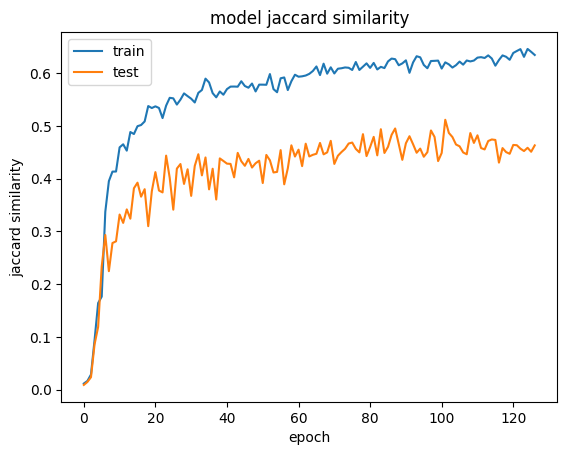

In [16]:
#plot history
plt.plot(history.history['jaccard_similarity'])
plt.plot(history.history['val_jaccard_similarity'])
plt.title('model jaccard similarity')
plt.ylabel('jaccard similarity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
X_test = []
img_size_target = 112
test = test_data
for data in test:
    X_new = preprocess_test(data, img_size_target)
    X_test += X_new
X_test = np.array(X_test)

In [32]:
X_test.shape

(1507, 112, 112)

In [56]:
y_pred = model.predict(X_test)

48/48 [==============================] - 16s 331ms/step


In [53]:
#flat in 2d array
y_pred = y_pred.reshape(-1, img_size_target, img_size_target)
y_pred[0].shape

(112, 112)

In [118]:
'''
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('output.mp4',fourcc, 1.0, (img_size_target,img_size_target))

for frame_count in range(len(y_pred)):
    img = y_pred[frame_count][:,:,0]
    img = (img).astype(np.uint8)
    out.write(img)
out.release()
'''

In [100]:
predictions = []
index = 0
for sample in test:
    video = sample['video']
    n_frames = video.shape[2]
    predicted_video = np.empty((video.shape[0], video.shape[1], 0), 'bool')
    for frame in range(n_frames):
        h, w = video.shape[1], video.shape[0]
        #print(y_pred[index].shape)
        resized_frame = cv2.resize(y_pred[index], (h, w), interpolation=cv2.INTER_CUBIC)
        #print(resized_frame.shape)
        predicted_video = np.dstack((predicted_video, resized_frame))
        index += 1
    predicted_video = np.array(predicted_video, 'bool')
    predictions.append({
        'name': sample['name'],
        'prediction': predicted_video
        }
    )

(586, 821, 103)
(586, 821, 103)
(587, 791, 52)
(587, 791, 52)
(583, 777, 69)
(583, 777, 69)
(582, 851, 61)
(582, 851, 61)
(732, 845, 53)
(732, 845, 53)
(583, 809, 84)
(583, 809, 84)
(582, 737, 78)
(582, 737, 78)
(587, 775, 125)
(587, 775, 125)
(730, 956, 76)
(730, 956, 76)
(587, 781, 104)
(587, 781, 104)
(583, 681, 68)
(583, 681, 68)
(587, 713, 90)
(587, 713, 90)
(587, 612, 78)
(587, 612, 78)
(587, 773, 73)
(587, 773, 73)
(707, 855, 39)
(707, 855, 39)
(731, 1007, 72)
(731, 1007, 72)
(583, 780, 106)
(583, 780, 106)
(583, 670, 63)
(583, 670, 63)
(594, 745, 51)
(594, 745, 51)
(583, 779, 62)
(583, 779, 62)


(586, 821, 103)


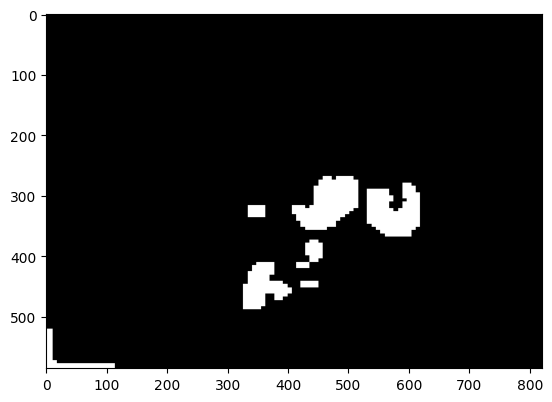

In [101]:
sample_pred = predictions[0]['prediction']
print(sample_pred.shape)
#plot sample prediction
plt.imshow(sample_pred[:,:,0], cmap='gray')
plt.show()

In [102]:
save_zipped_pickle(predictions, 'predictions.pkl')

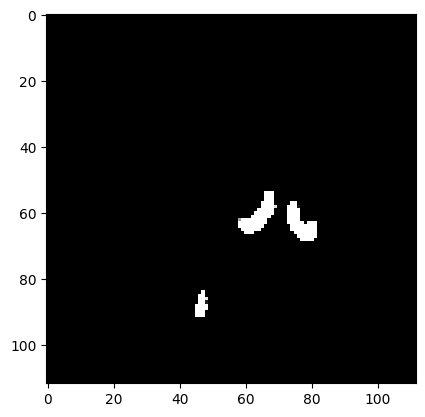

In [99]:
#plot prediction
plt.imshow(y_pred[0].reshape(112,112), cmap='gray')
plt.show()

In [ ]:
# make prediction for test
predictions = []
for d in test_data:
    prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)
    height = prediction.shape[0]
    width = prediction.shape[1]
    #prediction[int(height/2)-50:int(height/2+50), int(width/2)-50:int(width/2+50)] = True
    
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )

In [17]:

#cross validation with 5 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)
KFold(n_splits=5, random_state=0, shuffle=True)
for train_index, test_index in kf.split(X_train):
    X_train_k, X_test_k = X_train[train_index], X_train[test_index]
    y_train_k, y_test_k = y_train[train_index], y_train[test_index]
    model.fit(X_train_k, y_train_k, validation_data=[X_test_k, y_test_k], epochs=epochs,batch_size=batch_size, callbacks=[early_stopping, model_checkpoint])
    y_pred = model.predict(X_test_k)
    #ios = model.evaluate(y_pred, y_test)
    print(jaccard_similarity(y_pred, y_test_k))

Epoch 1/200
5/5 [==============================] - ETA: 0s - loss: -0.6312 - jaccard_similarity: 0.6332 - accuracy: 0.9958
Epoch 1: val_loss improved from -0.51193 to -0.65678, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


5/5 [==============================] - 15s 3s/step - loss: -0.6312 - jaccard_similarity: 0.6332 - accuracy: 0.9958 - val_loss: -0.6568 - val_jaccard_similarity: 0.6936 - val_accuracy: 0.9956
Epoch 2/200
5/5 [==============================] - ETA: 0s - loss: -0.6260 - jaccard_similarity: 0.6277 - accuracy: 0.9956
Epoch 2: val_loss improved from -0.65678 to -0.67302, saving model to ./keras.model


INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


5/5 [==============================] - 13s 3s/step - loss: -0.6260 - jaccard_similarity: 0.6277 - accuracy: 0.9956 - val_loss: -0.6730 - val_jaccard_similarity: 0.7008 - val_accuracy: 0.9961
Epoch 3/200
5/5 [==============================] - ETA: 0s - loss: -0.6152 - jaccard_similarity: 0.6143 - accuracy: 0.9959
Epoch 3: val_loss did not improve from -0.67302
5/5 [==============================] - 9s 2s/step - loss: -0.6152 - jaccard_similarity: 0.6143 - accuracy: 0.9959 - val_loss: -0.6584 - val_jaccard_similarity: 0.6781 - val_accuracy: 0.9960
Epoch 4/200
5/5 [==============================] - ETA: 0s - loss: -0.6304 - jaccard_similarity: 0.6172 - accuracy: 0.9958
Epoch 4: val_loss did not improve from -0.67302
5/5 [==============================] - 9s 2s/step - loss: -0.6304 - jaccard_similarity: 0.6172 - accuracy: 0.9958 - val_loss: -0.6258 - val_jaccard_similarity: 0.6100 - val_accuracy: 0.9949
Epoch 5/200
5/5 [==============================] - ETA: 0s - loss: -0.6318 - jaccard_si

INFO:tensorflow:Assets written to: ./keras.model/assets


INFO:tensorflow:Assets written to: ./keras.model/assets


5/5 [==============================] - 15s 3s/step - loss: -0.6441 - jaccard_similarity: 0.6512 - accuracy: 0.9959 - val_loss: -0.6755 - val_jaccard_similarity: 0.6938 - val_accuracy: 0.9961
Epoch 7/200
2/5 [===========>..................] - ETA: 6s - loss: -0.6346 - jaccard_similarity: 0.6346 - accuracy: 0.9959 

KeyboardInterrupt: 

In [ ]:
data_test = []
import cv2
from skimage.transform import resize

for video in test_data:
    if video["video"][0].shape != (112,112):
        val = video["video"].shape[-1]
        res = resize(video["video"], (val, 112, 112, 1))
        store = {}
        store["video"] = res
    
    else :
        store = {}
        store["video"] = res
    data_test.append(store)


In [ ]:
test_data[0]["video"].shape

In [ ]:
pred = resize(model.predict(data_test[0]["video"]), (583,863,84))

In [ ]:
np.where(pred.astype('bool') == True)